# MUSIC for Direction of Arrival

This notebook is a demo of MUSIC for Direction of Arrival

## Test on simulated data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.signal import find_peaks

In [2]:
# Constants
thetas = np.array([0.5, 1]) # in radians (should be in [0, pi/2])
n_sources = len(thetas)
w0 = np.pi / 4
n_mics = 20
mic_distance = 1
wavelength = 1
noise_var = 1
fs = 1

### Craft the signal

We create 2 ways of crafting a simulated signal:
1. With a simulated function that we sample
2. Directly with the matrices containing the samples of our function


With the function:

In [3]:
def narrowband_signal(k, w0):    
    def helper(t):
        # Use a hash as a seed to ensure that if (k1, t1) = (k2, t2), then we give the exact result
        rng = np.random.RandomState(hash((k, t)) & 0xffffffff)
        return rng.randn() * np.exp(-1j * w0 * t)
    return helper

def received_signal(thetas, narrowband_signals, mic_index, mic_distance=0.2, noise_var=0, wavelength=1):
    def helper(t):
        signal = 0
        for theta, narrowband in zip(thetas, narrowband_signals):
            phase = np.exp(-2j * np.pi * (mic_index - 1) * mic_distance * np.sin(theta) / wavelength)
            signal += narrowband(t) * phase
            
        return signal + np.random.normal(size=2, scale=noise_var).view(np.complex128)[0]
    
    return helper

In [8]:
narrowband_signals = [narrowband_signal(k, w0) for k in range(n_sources)]
received_signals = [received_signal(thetas, narrowband_signals, m+1, 
                                    mic_distance=mic_distance, noise_var=noise_var, wavelength=wavelength) for m in range(n_mics)]

n_samples = 100

sampled_received = np.zeros((len(received_signals), n_samples), dtype=np.csingle)

for i, received in enumerate(received_signals):
    for j in range(n_samples):
        sampled_received[i, j] = received(j / fs)

sampled_received.shape

(20, 100)

Directly with the samples:

In [5]:
phis = np.array([np.exp(-2j * np.pi * mic_distance * np.sin(theta) / wavelength) for theta in thetas])
A = np.vander(phis, n_mics, increasing=True).T
S = np.random.normal(0, 1, (n_sources, n_samples))
noise_matrix = np.random.normal(0, noise_var, (n_mics, n_samples, 2)).view(np.complex128).reshape((n_mics, n_samples))

sampled_received = (A @ S) + noise_matrix 

### Music implementation

In [6]:
def music(samples, n_sources):
    M = len(samples)
    
    samples = (samples.T - samples.mean(axis=1).T).T

    print('Samples shape:', samples.shape)
    covariance = samples @ samples.conj().T / M
    print("Covariance shape:", covariance.shape)
        
    eigenvalues, eigenvectors = np.linalg.eig(covariance)
        
    indices = np.argsort(eigenvalues)
    eigenvalues, eigenvectors = eigenvalues[indices], eigenvectors[:, indices]
    
    # Decompose signal and noise
    # Assumption : the noise has the smallest eigenvalues
    signal_eigenvalues, signal_eigenvectors = eigenvalues[-n_sources :], eigenvectors[:, -n_sources :]
    noise_eigenvalues, noise_eigenvectors = eigenvalues[: -n_sources], eigenvectors[:, : -n_sources]
    
    return signal_eigenvalues, signal_eigenvectors, noise_eigenvalues, noise_eigenvectors

In [9]:
signal_eigenvalues, signal_eigenvectors, noise_eigenvalues, noise_eigenvectors = music(sampled_received, n_sources)

Samples shape: (20, 100)
Covariance shape: (20, 20)


In [10]:
def spectrum_function(noise_eigenvectors, mic_distance, wavelength):    
    M = noise_eigenvectors.shape[0]
    def helper(sin_value):
        phi = 2 * np.pi * mic_distance * sin_value / wavelength
        x = [np.exp(-1j*phi)]
        a = np.vander(x, M, increasing=True)
        temp = a.conj() @ noise_eigenvectors
        
        return 1 / np.linalg.norm(temp)**2
    
    return helper

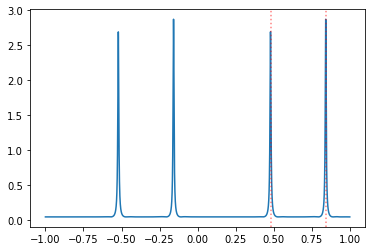

In [11]:
spectrum = spectrum_function(noise_eigenvectors, mic_distance=mic_distance, wavelength=wavelength)

X = np.linspace(-1, 1, 10000)
Y = [spectrum(x) for x in X]

plt.plot(X, Y)
for theta in thetas:
    plt.axvline(x=np.sin(theta), color='red', linestyle=':', alpha=0.5)
plt.show()

Extract the frequencies from the peaks. Note that our method only works for theta in $\left[0, \frac{\pi}{2} \right]$ because of the symmetry of the complex exponential and sinus function.

In [12]:
def extract_frequencies(spectrum, n_sources, input_range, resolution=1000):
    X = np.linspace(input_range[0], input_range[1], resolution)
    Y = np.array([spectrum(x) for x in X])
    
    threshold = np.sort(Y)[int(0.8 * resolution)]
    
    peak_indices, _ = find_peaks(Y, threshold)
    indices = np.argsort(Y[peak_indices])[-n_sources:]  # Sort peak indices by y value and take the top num_peaks    
    estimated_freq = peak_indices[indices]
    
    return (estimated_freq / resolution) * (input_range[1] - input_range[0]) + input_range[0]

In [13]:
sin_values = extract_frequencies(spectrum, n_sources, [0, 1])
estimated_thetas = []
for sv in sin_values:
    estimated_thetas.append(np.arcsin(sv))

print(estimated_thetas)

[0.4983763268163839, 0.9991288847176136]
